# Handwritten Digits Recognition Using Shallow Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Training data comes from the "MNIST" data set, you can download it from [Kaggle](https://www.kaggle.com/c/digit-recognizer/data).

## Section 1, Data Preparation

In [2]:
data = np.genfromtxt("train.csv", delimiter=',', skip_header=1)
print(data.shape)

(42000, 785)


In [3]:
np.random.shuffle(data)
print(data.shape)
print(data[:10, 0])

(42000, 785)
[2. 1. 5. 4. 5. 2. 2. 7. 2. 5.]


In [4]:
features = data[:, 1:].T
labels = data[:, 0]
labels = np.reshape(labels, (1, -1))
print(features.shape)
print(labels.shape)

(784, 42000)
(1, 42000)


In [5]:
m = features.shape[1]
nx = features.shape[0]
ny = 10

In [6]:
def labels_to_Y(labels):
    Y = np.zeros((ny, m))
    for i in range(m):
        Y[int(labels[0, i]), i] = 1
    return Y

def Y_to_labels(Y):
    labels = np.argmax(Y, axis=0).astype(float)
    labels = np.reshape(labels, (1, -1))
    return labels

def X_to_images(X):
    images = [np.reshape(X[:, i], (28, 28)) for i in range(X.shape[1])]
    return images

(10, 42000)
2.0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


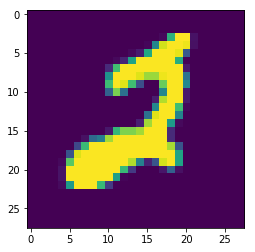

In [7]:
X = features / 255
Y = labels_to_Y(labels)
images = X_to_images(X)
print(Y.shape)
plt.imshow(images[0])
print(labels[0, 0])
print(Y[:, 0])

In [8]:
train_ratio = 0.9

In [9]:
test_ratio = 1 - train_ratio
train_m = int(m * train_ratio)
test_m = m - train_m
train_X = X[:, :train_m]
test_X = X[:, train_m:]
train_Y = Y[:, :train_m]
test_Y = Y[:, train_m:]
train_labels = Y_to_labels(train_Y)
test_labels = Y_to_labels(test_Y)
print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)
print(train_labels.shape)

(784, 37800)
(10, 37800)
(784, 4200)
(10, 4200)
(1, 37800)


## Section 2, Design Neural Network

In [10]:
def sigmoid(z):
    a = 1/ (1 + np.exp(-z))
    return a

def sigmoid_prime(z):
    p1 = np.exp(-z)
    a = p1/((1+p1)**2)
    return a

def relu(z):
    a = np.maximum(z, 0.01*z)
    return a

def relu_prime(z):
    a = np.where(z > 0, 1, 0.01)
    return a

def tanh(z):
    p1 = np.exp(z)
    p2 = np.exp(-z)
    a = (p1-p2)/(p1+p2)
    return a
    
def tanh_prime(z):
    p1 = tanh(z)
    a = 1-p1**2
    return a

def softmax(z):
    t = np.exp(z)
    n = np.sum(t, axis = 0)
    a = t/n
    return a

In [11]:
def loss_function_for__config_multi_layer_classifier_without_regularization(Y_hat, Y):
    delta = 1e-10
    l = np.sum(-Y*np.log(Y_hat+delta), axis=0)
    return l

def forward_propagation_for_config_multi_layer_classifier_without_regularization(model):
    X = model['X']
    Y = model['Y']
    n = model['n']
    L = model['L']
    f = model['f']
    W = model['W']
    b = model['b']
    Z = model['Z']
    A = model['A']
    costs = model['costs']
    loss_function = model['loss_function']
    A[0] = X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    costs.append(np.sum(loss_function(A[L], Y)))

def back_propagation_for_config_multi_layer_classifier_without_regularization(model):
    n = model['n']
    L = model['L']
    f_prime = model['f_prime']
    m = model['m']
    W = model['W']
    Z = model['Z']
    A = model['A']
    Y = model['Y']
    dW = model['dW']
    db = model['db']
    dA = model['dA']
    dZ = model['dZ']
    dZ[L] = A[L] - Y
    dW[L] = np.matmul(dZ[L], A[L-1].T)/m
    db[L] = np.sum(dZ[L], axis=1, keepdims=True)/m
    for i in reversed(range(1, L)):
        dZ[i] = np.matmul(W[i+1].T, dZ[i+1]) * f_prime[i](Z[i])
        dW[i] = np.matmul(dZ[i], A[i-1].T)/m
        db[i] = np.sum(dZ[i], axis=1, keepdims=True)/m
        
def update_for_config_multi_layer_classifier_without_regularization(model):
    L = model['L']
    W = model['W']
    b = model['b']
    dW = model['dW']
    db = model['db']
    learning_rate = model['learning_rate']
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    
    
def predict_for_config_multi_layer_classifier_without_regularization(model, test_X):
    L = model['L']
    A = model['A']
    Z = model['Z']
    W = model['W']
    b = model['b']
    f = model['f']
    A[0] = test_X
    for i in range(1, L+1):
        Z[i] = np.matmul(W[i], A[i-1]) + b[i]
        A[i] = f[i](Z[i])
    return A[L]
    
    
def config_multi_layer_classifier_without_regularization(X, Y, neuron_of_hidden_layer, learning_rate):
    n_input_layer = X.shape[0]
    n_output_layer = Y.shape[0]
    
    m = X.shape[1]
    n = [n_input_layer] + neuron_of_hidden_layer + [n_output_layer]
    L = len(n)-1
    f = [tanh if i != 0 else None for i in range(L)]
    f.append(softmax)
    f_prime = [tanh_prime if i != 0 else None for i in range(L)]
    f_prime.append(None)
    W = [np.random.normal(0, 1, (n[i], n[i-1])) if i != 0 else None for i in range(L+1)]
    b = [np.random.normal(0, 1, (n[i], 1)) if i != 0 else None for i in range(L+1)]
    Z = [None for i in range(L+1)]
    A = [None for i in range(L+1)]
    dW = [None for i in range(L+1)]
    db = [None for i in range(L+1)]
    dA = [None for i in range(L+1)]
    dZ = [None for i in range(L+1)]
    costs = []
    
    model = dict()
    model['X'] = X
    model['Y'] = Y
    model['m'] = m
    model['n'] = n
    model['L'] = L
    model['f'] = f
    model['f_prime'] = f_prime
    model['W'] = W
    model['b'] = b
    model['Z'] = Z
    model['A'] = A
    model['dW'] = dW
    model['db'] = db
    model['dA'] = dA
    model['dZ'] = dZ
    model['loss_function'] = loss_function_for__config_multi_layer_classifier_without_regularization
    model['costs'] = costs
    model['learning_rate'] = learning_rate
    model['forwardprop'] = forward_propagation_for_config_multi_layer_classifier_without_regularization
    model['backprop'] = back_propagation_for_config_multi_layer_classifier_without_regularization
    model['update'] = update_for_config_multi_layer_classifier_without_regularization
    model['predict'] = predict_for_config_multi_layer_classifier_without_regularization
    
    return model
        
    

In [12]:
def train_model(iteration_times, model):
    forwardprop = model['forwardprop']
    backprop = model['backprop']
    update = model['update']
    costs = model['costs']
    for i in range(iteration_times):
        forwardprop(model)
        backprop(model)
        update(model)
        print("iteration %d, current loss: %f" % (i, costs[len(costs)-1]))
        

In [27]:
model = config_multi_layer_classifier_without_regularization(train_X, train_Y, [28], 0.8)

iteration 0, current loss: 5411.901852
iteration 1, current loss: 5411.742682
iteration 2, current loss: 5411.583529
iteration 3, current loss: 5411.424393
iteration 4, current loss: 5411.265275
iteration 5, current loss: 5411.106175
iteration 6, current loss: 5410.947092
iteration 7, current loss: 5410.788026
iteration 8, current loss: 5410.628978
iteration 9, current loss: 5410.469947
iteration 10, current loss: 5410.310934
iteration 11, current loss: 5410.151938
iteration 12, current loss: 5409.992960
iteration 13, current loss: 5409.833999
iteration 14, current loss: 5409.675056
iteration 15, current loss: 5409.516130
iteration 16, current loss: 5409.357222
iteration 17, current loss: 5409.198332
iteration 18, current loss: 5409.039459
iteration 19, current loss: 5408.880603
iteration 20, current loss: 5408.721766
iteration 21, current loss: 5408.562946
iteration 22, current loss: 5408.404143
iteration 23, current loss: 5408.245358
iteration 24, current loss: 5408.086591
iteration 

iteration 203, current loss: 5379.970060
iteration 204, current loss: 5379.814793
iteration 205, current loss: 5379.659547
iteration 206, current loss: 5379.504323
iteration 207, current loss: 5379.349120
iteration 208, current loss: 5379.193938
iteration 209, current loss: 5379.038778
iteration 210, current loss: 5378.883640
iteration 211, current loss: 5378.728523
iteration 212, current loss: 5378.573427
iteration 213, current loss: 5378.418353
iteration 214, current loss: 5378.263300
iteration 215, current loss: 5378.108269
iteration 216, current loss: 5377.953259
iteration 217, current loss: 5377.798271
iteration 218, current loss: 5377.643305
iteration 219, current loss: 5377.488360
iteration 220, current loss: 5377.333437
iteration 221, current loss: 5377.178535
iteration 222, current loss: 5377.023655
iteration 223, current loss: 5376.868796
iteration 224, current loss: 5376.713960
iteration 225, current loss: 5376.559145
iteration 226, current loss: 5376.404351
iteration 227, c

iteration 403, current loss: 5349.350779
iteration 404, current loss: 5349.199860
iteration 405, current loss: 5349.048962
iteration 406, current loss: 5348.898085
iteration 407, current loss: 5348.747228
iteration 408, current loss: 5348.596393
iteration 409, current loss: 5348.445579
iteration 410, current loss: 5348.294785
iteration 411, current loss: 5348.144013
iteration 412, current loss: 5347.993261
iteration 413, current loss: 5347.842530
iteration 414, current loss: 5347.691820
iteration 415, current loss: 5347.541131
iteration 416, current loss: 5347.390463
iteration 417, current loss: 5347.239816
iteration 418, current loss: 5347.089189
iteration 419, current loss: 5346.938583
iteration 420, current loss: 5346.787998
iteration 421, current loss: 5346.637434
iteration 422, current loss: 5346.486890
iteration 423, current loss: 5346.336367
iteration 424, current loss: 5346.185865
iteration 425, current loss: 5346.035383
iteration 426, current loss: 5345.884923
iteration 427, c

iteration 603, current loss: 5319.562350
iteration 604, current loss: 5319.415283
iteration 605, current loss: 5319.268233
iteration 606, current loss: 5319.121200
iteration 607, current loss: 5318.974184
iteration 608, current loss: 5318.827186
iteration 609, current loss: 5318.680205
iteration 610, current loss: 5318.533242
iteration 611, current loss: 5318.386295
iteration 612, current loss: 5318.239366
iteration 613, current loss: 5318.092454
iteration 614, current loss: 5317.945559
iteration 615, current loss: 5317.798681
iteration 616, current loss: 5317.651821
iteration 617, current loss: 5317.504977
iteration 618, current loss: 5317.358151
iteration 619, current loss: 5317.211342
iteration 620, current loss: 5317.064549
iteration 621, current loss: 5316.917774
iteration 622, current loss: 5316.771016
iteration 623, current loss: 5316.624275
iteration 624, current loss: 5316.477551
iteration 625, current loss: 5316.330843
iteration 626, current loss: 5316.184153
iteration 627, c

iteration 803, current loss: 5290.463891
iteration 804, current loss: 5290.319810
iteration 805, current loss: 5290.175741
iteration 806, current loss: 5290.031685
iteration 807, current loss: 5289.887640
iteration 808, current loss: 5289.743607
iteration 809, current loss: 5289.599585
iteration 810, current loss: 5289.455576
iteration 811, current loss: 5289.311578
iteration 812, current loss: 5289.167592
iteration 813, current loss: 5289.023618
iteration 814, current loss: 5288.879656
iteration 815, current loss: 5288.735705
iteration 816, current loss: 5288.591765
iteration 817, current loss: 5288.447837
iteration 818, current loss: 5288.303921
iteration 819, current loss: 5288.160016
iteration 820, current loss: 5288.016123
iteration 821, current loss: 5287.872240
iteration 822, current loss: 5287.728370
iteration 823, current loss: 5287.584510
iteration 824, current loss: 5287.440662
iteration 825, current loss: 5287.296825
iteration 826, current loss: 5287.153000
iteration 827, c

iteration 1003, current loss: 5261.836552
iteration 1004, current loss: 5261.694113
iteration 1005, current loss: 5261.551678
iteration 1006, current loss: 5261.409248
iteration 1007, current loss: 5261.266821
iteration 1008, current loss: 5261.124400
iteration 1009, current loss: 5260.981982
iteration 1010, current loss: 5260.839569
iteration 1011, current loss: 5260.697161
iteration 1012, current loss: 5260.554756
iteration 1013, current loss: 5260.412356
iteration 1014, current loss: 5260.269960
iteration 1015, current loss: 5260.127568
iteration 1016, current loss: 5259.985180
iteration 1017, current loss: 5259.842796
iteration 1018, current loss: 5259.700417
iteration 1019, current loss: 5259.558041
iteration 1020, current loss: 5259.415670
iteration 1021, current loss: 5259.273302
iteration 1022, current loss: 5259.130938
iteration 1023, current loss: 5258.988578
iteration 1024, current loss: 5258.846223
iteration 1025, current loss: 5258.703871
iteration 1026, current loss: 5258

iteration 1199, current loss: 5233.976335
iteration 1200, current loss: 5233.834423
iteration 1201, current loss: 5233.692514
iteration 1202, current loss: 5233.550607
iteration 1203, current loss: 5233.408702
iteration 1204, current loss: 5233.266801
iteration 1205, current loss: 5233.124901
iteration 1206, current loss: 5232.983005
iteration 1207, current loss: 5232.841111
iteration 1208, current loss: 5232.699219
iteration 1209, current loss: 5232.557330
iteration 1210, current loss: 5232.415444
iteration 1211, current loss: 5232.273561
iteration 1212, current loss: 5232.131680
iteration 1213, current loss: 5231.989802
iteration 1214, current loss: 5231.847926
iteration 1215, current loss: 5231.706053
iteration 1216, current loss: 5231.564183
iteration 1217, current loss: 5231.422316
iteration 1218, current loss: 5231.280451
iteration 1219, current loss: 5231.138590
iteration 1220, current loss: 5230.996731
iteration 1221, current loss: 5230.854874
iteration 1222, current loss: 5230

iteration 1395, current loss: 5206.228923
iteration 1396, current loss: 5206.087794
iteration 1397, current loss: 5205.946670
iteration 1398, current loss: 5205.805552
iteration 1399, current loss: 5205.664438
iteration 1400, current loss: 5205.523330
iteration 1401, current loss: 5205.382228
iteration 1402, current loss: 5205.241131
iteration 1403, current loss: 5205.100039
iteration 1404, current loss: 5204.958952
iteration 1405, current loss: 5204.817871
iteration 1406, current loss: 5204.676796
iteration 1407, current loss: 5204.535725
iteration 1408, current loss: 5204.394661
iteration 1409, current loss: 5204.253601
iteration 1410, current loss: 5204.112548
iteration 1411, current loss: 5203.971499
iteration 1412, current loss: 5203.830457
iteration 1413, current loss: 5203.689420
iteration 1414, current loss: 5203.548388
iteration 1415, current loss: 5203.407362
iteration 1416, current loss: 5203.266342
iteration 1417, current loss: 5203.125327
iteration 1418, current loss: 5202

iteration 1591, current loss: 5178.704206
iteration 1592, current loss: 5178.564744
iteration 1593, current loss: 5178.425296
iteration 1594, current loss: 5178.285860
iteration 1595, current loss: 5178.146437
iteration 1596, current loss: 5178.007027
iteration 1597, current loss: 5177.867630
iteration 1598, current loss: 5177.728246
iteration 1599, current loss: 5177.588875
iteration 1600, current loss: 5177.449517
iteration 1601, current loss: 5177.310172
iteration 1602, current loss: 5177.170840
iteration 1603, current loss: 5177.031521
iteration 1604, current loss: 5176.892216
iteration 1605, current loss: 5176.752924
iteration 1606, current loss: 5176.613644
iteration 1607, current loss: 5176.474379
iteration 1608, current loss: 5176.335126
iteration 1609, current loss: 5176.195886
iteration 1610, current loss: 5176.056660
iteration 1611, current loss: 5175.917448
iteration 1612, current loss: 5175.778248
iteration 1613, current loss: 5175.639062
iteration 1614, current loss: 5175

iteration 1787, current loss: 5151.621332
iteration 1788, current loss: 5151.484336
iteration 1789, current loss: 5151.347350
iteration 1790, current loss: 5151.210374
iteration 1791, current loss: 5151.073407
iteration 1792, current loss: 5150.936451
iteration 1793, current loss: 5150.799504
iteration 1794, current loss: 5150.662566
iteration 1795, current loss: 5150.525638
iteration 1796, current loss: 5150.388720
iteration 1797, current loss: 5150.251811
iteration 1798, current loss: 5150.114912
iteration 1799, current loss: 5149.978022
iteration 1800, current loss: 5149.841142
iteration 1801, current loss: 5149.704271
iteration 1802, current loss: 5149.567409
iteration 1803, current loss: 5149.430557
iteration 1804, current loss: 5149.293713
iteration 1805, current loss: 5149.156879
iteration 1806, current loss: 5149.020054
iteration 1807, current loss: 5148.883239
iteration 1808, current loss: 5148.746432
iteration 1809, current loss: 5148.609634
iteration 1810, current loss: 5148

iteration 1983, current loss: 5124.907512
iteration 1984, current loss: 5124.771646
iteration 1985, current loss: 5124.635780
iteration 1986, current loss: 5124.499916
iteration 1987, current loss: 5124.364053
iteration 1988, current loss: 5124.228192
iteration 1989, current loss: 5124.092331
iteration 1990, current loss: 5123.956471
iteration 1991, current loss: 5123.820612
iteration 1992, current loss: 5123.684754
iteration 1993, current loss: 5123.548897
iteration 1994, current loss: 5123.413041
iteration 1995, current loss: 5123.277185
iteration 1996, current loss: 5123.141330
iteration 1997, current loss: 5123.005475
iteration 1998, current loss: 5122.869622
iteration 1999, current loss: 5122.733768
iteration 2000, current loss: 5122.597915
iteration 2001, current loss: 5122.462063
iteration 2002, current loss: 5122.326211
iteration 2003, current loss: 5122.190359
iteration 2004, current loss: 5122.054507
iteration 2005, current loss: 5121.918656
iteration 2006, current loss: 5121

iteration 2179, current loss: 5098.245564
iteration 2180, current loss: 5098.109202
iteration 2181, current loss: 5097.972838
iteration 2182, current loss: 5097.836471
iteration 2183, current loss: 5097.700102
iteration 2184, current loss: 5097.563730
iteration 2185, current loss: 5097.427356
iteration 2186, current loss: 5097.290979
iteration 2187, current loss: 5097.154600
iteration 2188, current loss: 5097.018219
iteration 2189, current loss: 5096.881836
iteration 2190, current loss: 5096.745451
iteration 2191, current loss: 5096.609064
iteration 2192, current loss: 5096.472675
iteration 2193, current loss: 5096.336284
iteration 2194, current loss: 5096.199891
iteration 2195, current loss: 5096.063497
iteration 2196, current loss: 5095.927101
iteration 2197, current loss: 5095.790703
iteration 2198, current loss: 5095.654304
iteration 2199, current loss: 5095.517904
iteration 2200, current loss: 5095.381503
iteration 2201, current loss: 5095.245100
iteration 2202, current loss: 5095

iteration 2375, current loss: 5071.606586
iteration 2376, current loss: 5071.471967
iteration 2377, current loss: 5071.337367
iteration 2378, current loss: 5071.202789
iteration 2379, current loss: 5071.068231
iteration 2380, current loss: 5070.933694
iteration 2381, current loss: 5070.799178
iteration 2382, current loss: 5070.664683
iteration 2383, current loss: 5070.530208
iteration 2384, current loss: 5070.395755
iteration 2385, current loss: 5070.261322
iteration 2386, current loss: 5070.126911
iteration 2387, current loss: 5069.992521
iteration 2388, current loss: 5069.858152
iteration 2389, current loss: 5069.723804
iteration 2390, current loss: 5069.589478
iteration 2391, current loss: 5069.455173
iteration 2392, current loss: 5069.320890
iteration 2393, current loss: 5069.186627
iteration 2394, current loss: 5069.052387
iteration 2395, current loss: 5068.918168
iteration 2396, current loss: 5068.783970
iteration 2397, current loss: 5068.649794
iteration 2398, current loss: 5068

iteration 2571, current loss: 5045.638399
iteration 2572, current loss: 5045.508004
iteration 2573, current loss: 5045.377630
iteration 2574, current loss: 5045.247276
iteration 2575, current loss: 5045.116941
iteration 2576, current loss: 5044.986627
iteration 2577, current loss: 5044.856332
iteration 2578, current loss: 5044.726057
iteration 2579, current loss: 5044.595802
iteration 2580, current loss: 5044.465567
iteration 2581, current loss: 5044.335352
iteration 2582, current loss: 5044.205156
iteration 2583, current loss: 5044.074981
iteration 2584, current loss: 5043.944825
iteration 2585, current loss: 5043.814688
iteration 2586, current loss: 5043.684572
iteration 2587, current loss: 5043.554475
iteration 2588, current loss: 5043.424398
iteration 2589, current loss: 5043.294340
iteration 2590, current loss: 5043.164303
iteration 2591, current loss: 5043.034284
iteration 2592, current loss: 5042.904286
iteration 2593, current loss: 5042.774307
iteration 2594, current loss: 5042

iteration 2767, current loss: 5020.456292
iteration 2768, current loss: 5020.329789
iteration 2769, current loss: 5020.203306
iteration 2770, current loss: 5020.076845
iteration 2771, current loss: 5019.950404
iteration 2772, current loss: 5019.823985
iteration 2773, current loss: 5019.697586
iteration 2774, current loss: 5019.571208
iteration 2775, current loss: 5019.444851
iteration 2776, current loss: 5019.318514
iteration 2777, current loss: 5019.192199
iteration 2778, current loss: 5019.065905
iteration 2779, current loss: 5018.939631
iteration 2780, current loss: 5018.813378
iteration 2781, current loss: 5018.687146
iteration 2782, current loss: 5018.560936
iteration 2783, current loss: 5018.434746
iteration 2784, current loss: 5018.308576
iteration 2785, current loss: 5018.182428
iteration 2786, current loss: 5018.056301
iteration 2787, current loss: 5017.930195
iteration 2788, current loss: 5017.804109
iteration 2789, current loss: 5017.678044
iteration 2790, current loss: 5017

iteration 2963, current loss: 4996.037985
iteration 2964, current loss: 4995.915064
iteration 2965, current loss: 4995.792155
iteration 2966, current loss: 4995.669259
iteration 2967, current loss: 4995.546376
iteration 2968, current loss: 4995.423505
iteration 2969, current loss: 4995.300646
iteration 2970, current loss: 4995.177799
iteration 2971, current loss: 4995.054964
iteration 2972, current loss: 4994.932141
iteration 2973, current loss: 4994.809331
iteration 2974, current loss: 4994.686532
iteration 2975, current loss: 4994.563744
iteration 2976, current loss: 4994.440969
iteration 2977, current loss: 4994.318205
iteration 2978, current loss: 4994.195453
iteration 2979, current loss: 4994.072711
iteration 2980, current loss: 4993.949982
iteration 2981, current loss: 4993.827263
iteration 2982, current loss: 4993.704556
iteration 2983, current loss: 4993.581860
iteration 2984, current loss: 4993.459175
iteration 2985, current loss: 4993.336501
iteration 2986, current loss: 4993

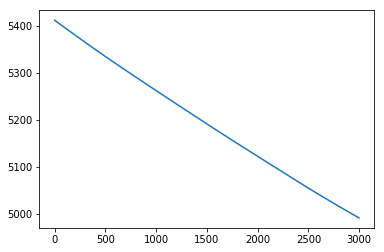

In [39]:
train_model(3000, model)
costs = model['costs']
plt.plot(costs[-3000:])
#print(W[1])

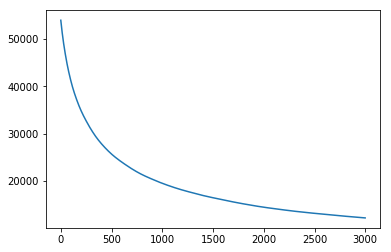

In [73]:
plt.plot(costs[-3000:])

## Section 3, Inspect Performance

In [15]:
def get_accuracy(pred, real):
    right = np.sum(pred==real)
    acc = right/real.shape[1]
    return acc

In [40]:
predict = model['predict']
pred = predict(model, train_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, train_labels)
print("training set accuracy: %f" % acc)
pred = predict(model, test_X)
pred = Y_to_labels(pred)
acc = get_accuracy(pred, test_labels)
print("test set accuracy: %f" % acc)

training set accuracy: 0.965026
test set accuracy: 0.921429


In [78]:
np.savez("W-four-layer", *W)
np.savez("b-four-layer", *b)

In [41]:
test_X = np.genfromtxt("test.csv", delimiter=',', skip_header=1)
test_X = test_X.T
test_X = test_X/255
print(test_X.shape)

(784, 28000)


In [43]:
test_Y = predict(model, test_X)
test_labels = Y_to_labels(test_Y)
print(test_labels.shape)

(1, 28000)


In [44]:
output = np.zeros((test_labels.shape[1], 2), dtype=int)
for i in range(output.shape[0]):
    output[i, 0] = i+1
    output[i, 1] = test_labels[0, i]

In [45]:
np.savetxt("4layer-submission.csv", output, fmt="%d", delimiter=',', header='ImageId,Label')

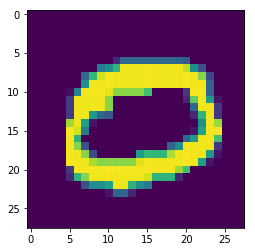

In [46]:
test_images = X_to_images(test_X)
plt.imshow(test_images[1])